# TensorFlow and other tools for ML in Julia

**Lyndon White**
 - Research Software Engineer -- Invenia Labs, Cambridge
 - Technically still PhD Candidate -- The University of Western Australia


In [1]:
using Pkg: @pkg_str
pkg"activate  ."

In [37]:
using MLDatasets
using Plots

In [2]:
using TensorFlow
using TensorFlow: summary

using Statistics

┌ Info: Recompiling stale cache file /Users/oxinabox/.julia/compiled/v1.1/TensorFlow/IhIhf.ji for TensorFlow [1d978283-2c37-5f34-9a8e-e9c0ece82495]
└ @ Base loading.jl:1184
┌ Warning: Loading a new version of TensorFlow.jl for the first time. This initial load can take around 5 minutes as code is precompiled; subsequent usage will only take a few seconds.
└ @ TensorFlow ~/Documents/oxinabox.github.io/_drafts/JuliaDeepLearningMeetupLondon2019/dev/TensorFlow/src/TensorFlow.jl:3


# Before TensorFlow
 
 - Researchers generally couldn't use Cafe etc as it is not suitably flexible.
 - One could use Theano, but it is painfully weird
 - Just write your neural networks by hand, as matrix math
 - And do your differenciation by hand, first with a blackboard then with more matrix math
 - While you are at it maybe write your own implementation of gradient descent etc
 - This was not long ago, I was still doing this in 2014
 - Julia is a fantasitic language to do this in.

# Static Graphs

 - Easy to manipulate mathematically and easy to think about
     - It is literally an AST for a language without control flow
        - i.e.  a language that is a lot like mathematical notation  
     - The dervitive of the graph can be calculated  via the chain rule -- generating another graph
 - Dynamic stuctures are impossible
     - A dynamic structure is on in which the network structure differs per input
     - RNNs have to be statically unrolled to their maximum length
     - If you want to represent say a tree structured network  (e.g. the work of Bowman, Socher and others for NLP)...  **Cry**

## 4 Types of Nodes, i.e. `Tensors`
 - **Placeholders:** this is where you put your inputs
 - **Operations:** theres transform inputs into outputs, they do math
 - **Variables:** thes arre the things you train, they are mutable
 - **Actions:** These are operations with side effects, like logging (TensorBoard)) and mutating Variable (Optimizers)

## Functions

Functions mutate **the graph** to introduce nodes.

For example:
 - `sin(::Float64)` in julia would return a `Float64` that is the answer.
 - `sin(::Tensor)` introduces a `sin` operation into the graph, and returns a `Tensor` that is a reference to it's output, this could be feed to other operations.
 
The answer to that operation is not computed, until you execute the graph.


In [5]:
sess= Session(Graph())

@tf begin
    x = placeholder(Float64)
    y = sin(x)
end

@show y

run(sess, y, Dict(x=>0.5))

y = <Tensor y:1 shape=unknown dtype=Float64>


2019-01-31 09:58:04.260210: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.2 AVX AVX2 FMA


0.479425538604203

In [7]:
# Create a summary writer
sess= Session(Graph())

@tf begin
    x = placeholder(Float64)
    y = sin(x)
end

@show y

run(sess, y, Dict(x=>0.5))
summary_writer = TensorFlow.summary.FileWriter(mkpath("logs"); graph=sess.graph)
x_summary = TensorFlow.summary.scalar("x", x)
y_summary = TensorFlow.summary.scalar("y", y)

merged_summary_op = TensorFlow.summary.merge_all()

for (ii, x_val) in enumerate(-1:0.1:1)
    y_val, summaries = run(sess, [y, merged_summary_op], Dict(x=>x_val))
    write(summary_writer, summaries,  ii)
end


y = <Tensor y:1 shape=unknown dtype=Float64>


In [24]:
sess= Session(Graph())

@tf begin
    x = placeholder(Float64)
    y = sin(x)
end

summary_writer = TensorFlow.summary.FileWriter(mkpath("logs"); graph=sess.graph)
close(summary_writer)

In [23]:
event = TensorFlow.tensorflow.Event()
data=convert(Vector{UInt8}, collect("\n,\n\x01x\x12\vPlaceholder*\v\n\x05dtype\x12\x020\x02*\r\n\x05shape\x12\x04:\x02\x18\x01\n\x14\n\x01y\x12\x03Sin\x1a\x01x*\a\n\x01T\x12\x020\x02\x12\0\"\x02\b\x1a"))
setfield!(event, :graph_def, data)
write(summary_writer, event)


In [ ]:
using TensorFlow
using TensorFlow: summary
logdir = "logs"
mkpath(logdir)

sess= Session(Graph())

@tf begin
    x = placeholder(Float64)
    y = sin(x)
end

summary_writer = TensorFlow.summary.FileWriter(logdir; graph=sess.graph)
close(summary_writer)


## Automatic Node Naming

 - Notice before I did `@tf begin ... end`
 - **This is not at all required**
 - But it does enable automatic node naming
 - so `@tf y = sin(x)` actually becomes `y = sin(x; name="y")`
 - This gives you a good graph in tensorboard, and also better error messages.
 - Further it lets us look up tensors from the graph by **name**

In [8]:
@show sess.graph["x"]
@show sess.graph["y"]

run(sess, sess.graph["y"], Dict(sess.graph["x"]=>0.5))

sess.graph["x"] = <Tensor x:1 shape=unknown dtype=Float64>
sess.graph["y"] = <Tensor y:1 shape=unknown dtype=Float64>


0.479425538604203

# Lets have an exciting Demo

![](https://white.ucc.asn.au/posts_assets/Intro%20to%20Machine%20Learning%20with%20TensorFlow.jl_files/Intro%20to%20Machine%20Learning%20with%20TensorFlow.jl_28_0.png) 

In [9]:
using TensorFlow
using MLDataUtils
using MLDatasets

#using ProgressMeter

┌ Info: Precompiling MLDataUtils [cc2ba9b6-d476-5e6d-8eaf-a92d5412d41d]
└ @ Base loading.jl:1186


In [82]:
sess = Session(Graph())

leaky_relu6(x) = 0.01x + nn.relu6(x)

# Network Definition
@tf begin
    X = placeholder(Float32, shape=[-1, 28*28])
    
    # Network parameters
    hl_sizes = [512, 128, 64, 2, 64, 128, 512]

    Zs = [X]
    for (ii, hlsize) in enumerate(hl_sizes)
        Wii = get_variable("W_$ii", [get_shape(Zs[end], 2), hlsize], Float32)
        bii = get_variable("b_$ii", [hlsize], Float32)
        Zii = leaky_relu6(Zs[end]*Wii + bii)
        push!(Zs, Zii)
    end
    
    Wout = get_variable([get_shape(Zs[end], 2), 28*28], Float32)
    bout = get_variable([28*28], Float32)
    Y = nn.sigmoid(Zs[end]*Wout + bout)
    
    
    Z_code = Zs[end÷2 + 1] # A name for the coding layer
    @assert get_shape(Z_code,2) == 2
end

losses = 0.5(Y .- X).^2
loss = reduce_mean(losses)
optimizer = train.minimize(train.AdamOptimizer(), loss)

<Tensor Group:1 shape=() dtype=Float32>

In [83]:
train_images = MNIST.traintensor()
test_images = MNIST.testtensor();

In [84]:

function one_image(img::Vector, frames_image_res=30)
    ret = zeros((frames_image_res, frames_image_res))
    ret[2:end-1, 2:end-1] = 1 .- rotl90(reshape(img, (28,28)))
    ret
end

function scatter_image(images, res; frames_image_res=30, no_overlap=false)
    canvas = ones(res, res)
    images = reshape(images, (28*28, :));
    codes = run(sess, Z_code, Dict(X=>images'))
    for ii in 1:2
        codes[:,ii] = (codes[:,ii] .- minimum(codes[:,ii]))./(maximum(codes[:,ii])-minimum(codes[:,ii]))
        @assert(minimum(codes[:,ii]) >= 0.0)
        @assert(maximum(codes[:,ii]) <= 1.0)
    
    end
    
    function target_area(code)
        central_res = res-frames_image_res-1
        border_offset = frames_image_res/2 + 1
        x,y = code*central_res .+ border_offset
        
        get_pos(v) = round(Int, v-frames_image_res/2)
        x_min = get_pos(x)
        x_max = x_min + frames_image_res-1
        y_min =  get_pos(y)
        y_max = y_min + frames_image_res-1
        
        @view canvas[x_min:x_max, y_min:y_max]
    end
    
    for ii in 1:size(codes, 1)
        code = codes[ii,:]
        img = images[:,ii]
        area = target_area(code)        
        no_overlap && any(area.<1) && continue # Don't draw over anything
        area[:] = one_image(img, frames_image_res)
    end
    canvas
end

scatter_image (generic function with 1 method)

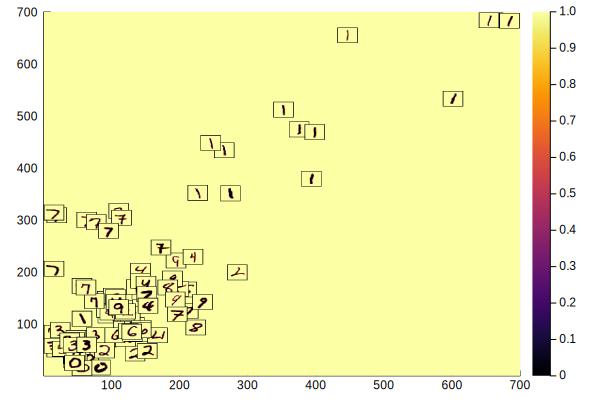

Epoch 20 loss: 0.021423440530059012


In [86]:
#run(sess, global_variables_initializer())
auto_loss = Float64[]
for epoch in 1:20
    epoch_loss = Float64[]
    for batch_x in eachbatch(train_images, 1_000, ObsDim.Last())
        flat_batch_x = reshape(batch_x, (28*28, :))
        loss_o, _ = run(sess, (loss, optimizer), Dict(X=>flat_batch_x'))
        push!(epoch_loss, loss_o)
    end
    push!(auto_loss, mean(epoch_loss))
    
    #
    println("Epoch $epoch loss: $(auto_loss[end])")
    display(heatmap(scatter_image(test_images[:,:,1:100], 700)))
    IJulia.clear_output(true)
end

# Lets break that example down

## Defining a Custom Activation Function
```
leaky_relu6(x) = 0.01x + nn.relu6(x)
```

 - Trival in the modern day with Flux, etc
 - When TensorFlow came out, this was insane wizard tricks, for Cafe users.
 - But now we take it for granted.
 - Note that to do this TensorFlow needed to basically implement a full linear algebra and math library.

## Building up our layers

```
    Zs = [X]
    for (ii, hlsize) in enumerate(hl_sizes)
        Wii = get_variable("W_$ii", [get_shape(Zs[end], 2), hlsize], Float32)
        bii = get_variable("b_$ii", [hlsize], Float32)
        Zii = leaky_relu6(Zs[end]*Wii + bii)
        push!(Zs, Zii)
    end
```

Remember what we are actually doing here is mutating the graph.


## MLDataUtils for training helpers

```
    for batch_x in eachbatch(train_images, 1_000, ObsDim.Last())
        flat_batch_x = reshape(batch_x, (28*28, :))
        loss_o, _ = run(sess, (loss, optimizer), Dict(X=>flat_batch_x'))
        push!(epoch_loss, loss_o)
    end
```

 - MLDataUtils is a fantastic julia package full of helpers useful with all ML packages
 - Use it with TensorFlow, use it with Flux, use it with Knet
 - `eachbatch`/ `batchview`
 - `eachobs`/`obsview`
 - Various stratified sampling, `oversample`, `undersample`
 - test/train splitting

# A Complicated Output Layer for HSV Color
 - Saturation and Value are easy, but Hue is angular
$$
loss =
\frac{1}{2} \left(\sin(y^\star_{hue}) - y_{shue} \right)^2     
+ \frac{1}{2} \left(\cos(y^\star_{hue}) - y_{chue} \right)^2  
+ \left(y^\star_{sat} - y_{sat} \right)^2  
+ \left(y^\star_{val} - y_{val} \right)^2 %
$$
 
<img src="./figs/hsv_output_module.png" width="50%" height="50%"/>


# Syntax Overloading


```julia
function hsv_output_layer(Y_logit::Tensor{Float32})
    # Y_logit # Y_logit [missing, 4] 

    
    # Prediction 
    Y_sat = nn.sigmoid(Y_logit[:,3])  # range 0:1
    Y_val = nn.sigmoid(Y_logit[:,4])  # range 0:1

    Y_shue = tanh(Y_logit[:,1])       # range -1:1 -- like sin
    Y_chue = tanh(Y_logit[:,2])       # range -1:1 -- like cos


    # Obs 
    Y_obs = placeholder(Float32; shape=[-1, 3])
    Y_obs_hue = Y_obs[:,1]                       # Notice proper indexing         
    Y_obs_sat = Y_obs[:,2]
    Y_obs_val = Y_obs[:,3]

    Y_obs_shue = sin(Float32(2π) .* Y_obs_hue)
    Y_obs_chue = cos(Float32(2π) .* Y_obs_hue)
    
    
    # Loss                        
    loss_hue = 0.5reduce_mean((Y_shue - Y_obs_shue)^2 + (Y_chue - Y_obs_chue)^2))
    loss_sat = reduce_mean((Y_sat-Y_obs_sat)^2)
    loss_val = reduce_mean((Y_val-Y_obs_val)^2)

    loss_total = identity(loss_hue + loss_sat + loss_val)

                        
    # For Output, we want hue angle measured in 0:1 (units of turns)
    Y_hue_o1 = Ops.atan2(Y_shue, Y_chue)/(2Float32(π))
    Y_hue_o2 = select(Y_hue_o1 > 0, Y_hue_o1, Y_hue_o1+1) # Wrap around things below 0
    Y_hue = reshape(Y_hue_o2, [-1]) # force shape

    Y = identity([Y_hue Y_sat Y_val]) # *** Notice Julia Style hcat***

    return loss_total
end
```

## Overloading hcat & vcat

So that `[a b]` and `[a; b]` work.
vs Base Tensorflow, would have you first make sure everything is the same number of dimensions,
then `concat` them,
And you couldn't use julia style syntax.

https://github.com/malmaud/TensorFlow.jl/blob/7099f05f523556829164aab41eccd394d29df898/src/ops/transformations.jl#L129-L150


## Overloading getindex

So that `X[a:b]`, `X[a]`, `X[:, end÷2]` etc.

https://github.com/malmaud/TensorFlow.jl/blob/master/src/ops/indexing.jl


# TensorFlow.jl Conventions vs Julia Conventions vs Python TensorFlow Conventions


**Julia**: 1-based indexing   
**Python TF**: 0-based indexing  
**TensorFlow.jl**: 1-based indexing   


**Julia:** explicit broadcasting   
**Python TF:** implicit broadcasting   
**TensorFlow.jl:** implicit or explicit broadcasting  


**Julia:**  last index at `end`, 2nd last in `end-1`, etc.   
**Python TF:** last index at `-1` second last in `-2`   
**TensorFlow.jl** last index at `end` 2nd last in `end-1`  


**Julia:**  Operations in Julia ecosystem namespaces. (`SVD` in `LinearAlgebra`, `erfc` in `SpecialFunctions`, `cos` in `Base`)   
**Python TF:** All operations in TensorFlow's namespaces (`SVD` in `tf.linalg`, `erfc` in `tf.math`, `cos` in `tf.math`, and all reexported from `tf`)  
**TensorFlow.jl**  Existing Julia functions overloaded to call TensorFlow equivalents when called with TensorFlow arguments  
 

**Julia:** Container types are parametrized by number of dimensions and element type   
**Python TF:** N/A -- python does not have a parametric type system   
**TensorFlow.jl:** Tensors are parametrized by element type.  

#  Windows Support
## No...

 - I've not tried to get this working in  a while but last time:
 - Unending segfaults on basic operations.
 - In theory it should just work.

#  TFEager
## Work In Progress

 - Google apparently wants this.
 - But why? I have a perfectly nice eager NN framework called Flux


# Dropping the Python Dependency
 - Python dependency is a nasty hack
 - It is basically only used for getting gradients.
 - we actually interact with it primarily by:
     - exporting the graph
     - running some Python TF on it
     - Importing the modified graph back
     
 - We need it for gradients as they are not in the C API
 - They are coming to the C API, but not ready yet.]]
 

# Invenia Labs
## We're hiring
### People who know Julia
### People who know Machine Learning
I have left some fliers about open positions at the entrance.